My own implementation of the Adam algorithm, except for some of the matplotlib which I just blatantly copied from one of the resources.
## Lessons learned
- WATCH OUT FOR SYNTAX RUNTIME ERRORS!! They can be a pain in the arse!
- mhat and vhat are useful because we have an exponential function that, during the intial t-steps, will tend towards zero
- A high beta_1 / beta_2 ratio, as well as a large alpha (step size, learning rate, you name it) can lead to overshooting
## Resources
- Adam, starting from less complex optimizers: https://towardsdatascience.com/a-visual-explanation-of-gradient-descent-methods-momentum-adagrad-rmsprop-adam-f898b102325c
- Adam's implementation in Python: https://machinelearningmastery.com/adam-optimization-from-scratch/
- What are beta_1 and beta_2? https://stats.stackexchange.com/a/419052
- Why correct the bias? https://stats.stackexchange.com/questions/232741/why-is-it-important-to-include-a-bias-correction-term-for-the-adam-optimizer-for
- Good explainer on various optimizers: https://www.ruder.io/optimizing-gradient-descent/
- Interesting functions to test it on: https://en.wikipedia.org/wiki/Test_functions_for_optimization


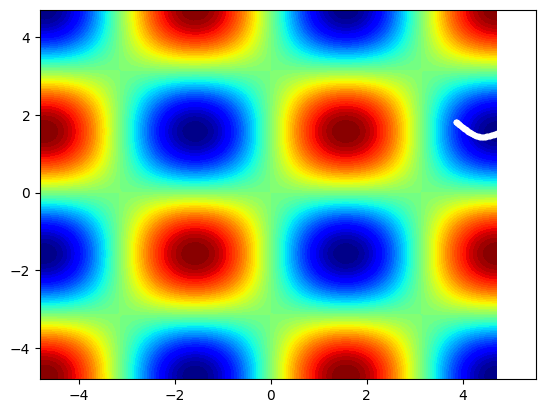

In [222]:
from math import sqrt
# we import these from numpy because we later use mesh grids, and only numpy will take those types of inputs
from numpy import sin, cos
import random
import matplotlib.pyplot as plt
from numpy import asarray, zeros, arange
from numpy import meshgrid

# in NNs, this would be like the cost function; the thing we're trying to minimize
def objective_function(x, y):
    # return x**2 + y**2
    return sin(x) * sin(y)

# in NNs, the inputs here would be the parameters
# suppose we wanted to know the derivative of the obj. f. in relation to the weights
# it would be like \p(artial) C / \p w 
# and so on for other parameters
# technically we will be blind to the objective function, and we can only sample it from runs with a set of parameters. We can however take
# it sderivative in relation to parameters.
def derivative_objective_function(x, y):
    # I think it would be better if we returned for only 1 input axis - but for this use case we'll use both at once anyway so it's fine
    return asarray([cos(x) * sin(y), cos(y) * sin(x)])
    # return asarray([2*x, 2*y])

# the objective function would be our cost function - we use it here to test the new point
# you can think of beta1 & beta2 as "decay rates"
def adam(n_steps, bounds, learning_rate, beta1, beta2, obj_fun, deriv_obj_fun, epsilon=1e-8):
    solutions = []
    n_axes = len(bounds)

    # random initial point
    point = zeros(n_axes)
    for idx, [min, max] in enumerate(bounds):
        point[idx] = random.uniform(min, max)
    solutions.append(point)

    # "g" standing for gradient
    cumulative_g_sum = zeros(n_axes)
    cumulative_g_sum_squared = zeros(n_axes)

    for t in range(n_steps):
        # numpy is very smart and will track the same array object even when we append it to `solutions`. However, we do need a new copy of it
        point = point.copy()

        gradient = deriv_obj_fun(point[0], point[1])
        for axis in range(n_axes):
            cumulative_g_sum[axis] = cumulative_g_sum[axis] * beta1 + (gradient[axis] * (1.0-beta1))
            # it's fine if we lose the negative sign with the squared sum - on the final "delta" we'll still have the sign from the cumulative_g_sum!
            cumulative_g_sum_squared[axis] = cumulative_g_sum_squared[axis] * beta2 + (gradient[axis]**2 * (1.0-beta2))
            # we need bias correction because we start with 0's - if you need to know more, search into "Adam bias correction" or something like that
            # this correction dies out over time, since beta2**t<1,
            # therefore the denominator yields increasing values over time
            # and the final fraction is overall smaller
            # SINCE T STARTS AT 0, DO T+1 OTHERWISE... The terrors of division by 0 unfold.
            corrected_c_g_s = cumulative_g_sum[axis] / (1.0 - beta1 ** t+1)
            corrected_c_g_s_squared = cumulative_g_sum_squared[axis] / (1.0 - beta2 ** t+1)
            # we flip the sign because the gradient points upward - but we want to go downward!
            delta = -learning_rate * (corrected_c_g_s / (sqrt(corrected_c_g_s_squared) + epsilon))
            # delta = -learning_rate * (corrected_c_g_s[axis])
            point[axis] += delta
        solutions.append(point)
        cost = objective_function(point[0], point[1])
        # if we get close enough, just return it already
        # if cost <= -.99:
        #     return solutions
    return solutions

# some hyperparameters
n_steps = 200
bounds = asarray([
    [-4, 4],
    [-4, 4]
])
beta1 = .99
beta2 = .999
learning_rate = 0.01
# compute targets
results = adam(n_steps, bounds, learning_rate, beta1, beta2, objective_function, derivative_objective_function)
results = asarray(results)

# create a display that's larger in case the algorithm goes out of bounds
f_bounds = bounds.copy() * 1.2
# sample input range uniformly at 0.1 increments
xaxis = arange(f_bounds[0,0], f_bounds[0,1], 0.1)
yaxis = arange(f_bounds[1,0], f_bounds[1,1], 0.1)
# create a mesh from the axis
x, y = meshgrid(xaxis, yaxis)
# get result (z) for mesh
z = objective_function(x, y)

fig = plt.figure()
# create a filled contour plot with 50 levels and jet color scheme
plt.contourf(x, y, z, levels=50, cmap='jet')
plt.plot(results[:, 0], results[:, 1], '.-', color='w')
plt.show()

code from https://machinelearningmastery.com/adam-optimization-from-scratch/
with some extra fiddling & comments

[[-4.  4.]
 [-4.  4.]] 2
p 0 m1 0.0 g -0.33276265233333896 m2 -0.0033276265233333924 with b 0.99
p 1 m1 0.0 g -0.5509756551229876 m2 -0.005509756551229881 with b 0.99
p 0 m1 -0.0033276265233333924 g -0.3230520716862271 m2 -0.0065248709749623325 with b 0.99
p 1 m1 -0.005509756551229881 g -0.5412650747081762 m2 -0.01086730973279935 with b 0.99
p 0 m1 -0.0065248709749623325 g -0.31265056119873313 m2 -0.009586127877200043 with b 0.99
p 1 m1 -0.01086730973279935 g -0.530865454827641 m2 -0.01606729118374777 with b 0.99
p 0 m1 -0.009586127877200043 g -0.30157542486737765 m2 -0.012506020847101822 with b 0.99
p 1 m1 -0.01606729118374777 g -0.5197958627567558 m2 -0.021104576899477857 with b 0.99
p 0 m1 -0.012506020847101822 g -0.28984538322785536 m2 -0.01527941447090936 with b 0.99
p 1 m1 -0.021104576899477857 g -0.5080772475863347 m2 -0.02597430360634643 with b 0.99
p 0 m1 -0.01527941447090936 g -0.2774805965564105 m2 -0.017901426291764375 with b 0.99
p 1 m1 -0.02597430360634643 g -0.4957325481

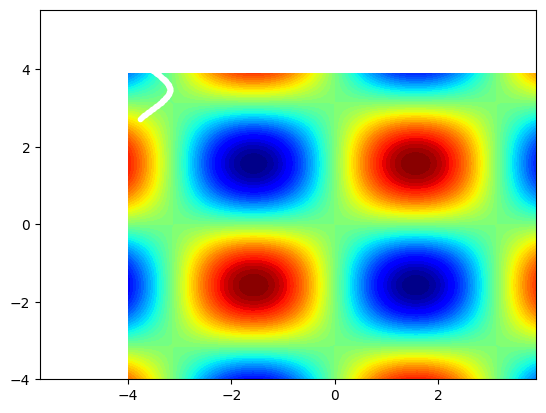

In [210]:
from math import sqrt
from numpy import asarray
from numpy import arange
from numpy import sin, cos
from numpy.random import rand
from numpy.random import seed
from numpy import meshgrid
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
 
# objective function
def objective(x, y):
 return sin(x) * sin(y)
#  return sin(x) * sin(y) - x - y

# derivative of objective function
def derivative(x, y):
 return asarray([cos(x) * sin(y), cos(y) * sin(x)])
#  return asarray([cos(x) * sin(y) - 1, cos(y) * sin(x) - 1])
 
# gradient descent algorithm with adam
def adam(objective, derivative, bounds, n_iter, alpha, beta1, beta2, eps=1e-8):
    solutions = list()
    # generate an initial point
    x = bounds[:, 0] + rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0])
    score = objective(x[0], x[1])
    # initialize first and second moments
    m = [0.0 for _ in range(bounds.shape[0])]
    v = [0.0 for _ in range(bounds.shape[0])]
    # run the gradient descent updates
    print(bounds, bounds.shape[0])
    for t in range(n_iter):
        # calculate gradient g(t)
        g = derivative(x[0], x[1])
        # build a solution one variable at a time
        # bounds.shape[0] in this case returns 2 because our function has 2 dimensions
        for i in range(bounds.shape[0]):
            # m(t) = beta1 * m(t-1) + (1 - beta1) * g(t)
            print('p', i, 'm1', m[i], 'g', g[i], end=' ')
            m[i] = beta1 * m[i] + (1.0 - beta1) * g[i]
            print('m2', m[i], 'with b', beta1)

            # v(t) = beta2 * v(t-1) + (1 - beta2) * g(t)^2
            v[i] = beta2 * v[i] + (1.0 - beta2) * g[i]**2
            # mhat(t) = m(t) / (1 - beta1(t))
            mhat = m[i] / (1.0 - beta1**(t+1))
            # vhat(t) = v(t) / (1 - beta2(t))
            vhat = v[i] / (1.0 - beta2**(t+1))
            # x(t) = x(t-1) - alpha * mhat(t) / (sqrt(vhat(t)) + ep)
            x[i] = x[i] - alpha * mhat / (sqrt(vhat) + eps)
        # evaluate candidate point
        score = objective(x[0], x[1])
        # keep track of solutions
        solutions.append(x.copy())
        # report progress
        # print('>%d f(%s) = %.5f' % (t, x, score))
    return solutions

# seed the pseudo random number generator
# seed(4)
# define range for input
bounds = asarray([[-4.0, 4.0], [-4.0, 4.0]])
# define the total iterations
n_iter = 200
# steps size
alpha = 0.02
# factor for average gradient
beta1 = 0.99
# factor for average squared gradient
beta2 = 0.999
# perform the gradient descent search with adam
solutions = adam(objective, derivative, bounds, n_iter, alpha, beta1, beta2)
# sample input range uniformly at 0.1 increments
xaxis = arange(bounds[0,0], bounds[0,1], 0.1)
yaxis = arange(bounds[1,0], bounds[1,1], 0.1)
# create a mesh from the axis
x, y = meshgrid(xaxis, yaxis)
# compute targets
results = objective(x, y)
# create a filled contour plot with 50 levels and jet color scheme
pyplot.contourf(x, y, results, levels=50, cmap='jet')
# plot the sample as black circles
solutions = asarray(solutions)
pyplot.plot(solutions[:, 0], solutions[:, 1], '.-', color='w')
# show the plot
pyplot.show()